In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from time import time
from skimage import io

from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

import matplotlib.pyplot as plt
from scipy.misc import imread
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import h5py
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:

"""
Args:
    base: base folder name in which files are located
    SRF: image_SRF folder to select
    n_ids: number of ids to generated from 1...n_ids
Returns:
    A numpy character array of filenames
"""
def gen_filenames_labels(base, SRF, n_ids):
    basepath = base + SRF
    
    dataset_arr = np.chararray(shape=(n_ids, 2), itemsize=128)
    
    for i in range(1, n_ids+1):
        Y = basepath + 'img_{:03}_SRF_2_HR.png'.format(i)
        X = basepath + 'img_{:03}_SRF_2_bicubic.png'.format(i)
        X_dash = basepath + 'img_{:03}_SRF_2_LR.png'.format(i)
        
        dataset_arr[i-1, 0] = X
        dataset_arr[i-1, 1] = Y
    
    return dataset_arr

dataset = gen_filenames_labels('train/', 'image_SRF_2/', 100)
val_dataset = gen_filenames_labels('Set5/', 'image_SRF_2/', 5)

X_train, X_test, y_train, y_test = dataset[:, 0], val_dataset[:, 0], dataset[:, 1], val_dataset[:, 1]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(100,) (100,) (5,) (5,)


In [3]:
"""
Class to store parameters which would be required to build and train model
"""

class ModelParameters:
    def __init__(self):
        self.batch_size = 256
        self.input_height = 33
        self.input_width = 33
        self.n_channels = 3
        self.n_epochs = 1000
        self.learning_rate = 3.0490316476061707e-06
        self.decay_rate = 0.9
        self.decay_steps = 1e+4

params = ModelParameters()

"""
Builds a tensorflow graph to be used for loading files into memory. ETL process

Args:
    filename: filename
    ksizes: A list of ints that has length >= 4. 
            The size of the sliding window for each dimension of images
    strides: A list of ints that has length >= 4. 
            1-D of length 4. How far the centers of two consecutive patches are in the images. 
            Must be: [1, stride_rows, stride_cols, 1].
    rates: A list of ints that has length >= 4. 1-D of length 4. 
            Must be: [1, rate_rows, rate_cols, 1]. 
            This is the input stride, specifying how far two consecutive patch samples are in the input. 
            Equivalent to extracting patches with patch_sizes_eff = patch_sizes + (patch_sizes - 1) * (rates - 1), 
            followed by subsampling them spatially by a factor of rates. 
            This is equivalent to rate in dilated (a.k.a. Atrous) convolutions.
            
Returns:
    Batch of patches extracted from the image.
"""
def get_img_from_file(filename, ksizes, kstrides, rates):
    file = tf.read_file(filename)
    img = tf.image.decode_png(file, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    patches = tf.image.extract_image_patches(tf.expand_dims(img, 0), 
                                             ksizes, 
                                             kstrides, 
                                             rates, 
                                             padding='VALID')

    input_img_batch = tf.squeeze(patches)
    shape = tf.shape(input_img_batch)
    input_img_batch = tf.reshape(input_img_batch, [shape[0]*shape[1], 
                                                   params.input_height, 
                                                   params.input_width, 
                                                   params.n_channels])
    return input_img_batch

In [4]:
"""
A class for building graph that loads and initializes iterators for loading data into graph
"""

class DataLoader:
    def __init__(self, X_train, y_train, X_test, y_test, params):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.params = params
        self.ksizes = [1, params.input_height, params.input_width, 1]
        self.kstrides = [1, 10, 10, 1]
        self.rates = [1, 1, 1, 1]
        
    """
    Args:
        num_threads: number of parallel calls to be made while parsing
        num_prefetch: number of batches to be pre loaded before training
        
    Returns:
        Next batch to be served to model
    
    """
    def build_iterators(self, num_threads=8, num_prefetch=8):
        def parse_fn(filename, label):
            input_img_batch = get_img_from_file(filename, self.ksizes, self.kstrides, self.rates)

            ground_img_batch = get_img_from_file(label, self.ksizes, self.kstrides, self.rates)

            return (input_img_batch, ground_img_batch)
        
 
        #train dataset graph
        filenames = self.X_train
        labels = self.y_train
        
        train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        train_dataset = train_dataset.shuffle(len(filenames))
        train_dataset = train_dataset.map(parse_fn, num_parallel_calls=num_threads)
        train_dataset = train_dataset.apply(tf.contrib.data.unbatch())
        train_dataset = train_dataset.batch(self.params.batch_size)
        self.train_dataset = train_dataset.prefetch(num_prefetch)
        
        #val dataset graph
        filenames = self.X_test
        labels = self.y_test
        
        val_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        val_dataset = val_dataset.shuffle(len(filenames))
        val_dataset = val_dataset.map(parse_fn, num_parallel_calls=num_threads)
        val_dataset = val_dataset.apply(tf.contrib.data.unbatch())
        val_dataset = val_dataset.batch(self.params.batch_size)
        self.val_dataset = val_dataset.prefetch(num_prefetch)

        #Make iterator
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types, 
                                                   train_dataset.output_shapes)
        next_element = iterator.get_next()
        
        self.train_init_op = iterator.make_initializer(self.train_dataset)
        self.val_init_op = iterator.make_initializer(self.val_dataset)
        
        return next_element
        

In [5]:
from sklearn.feature_extraction.image import extract_patches_2d
from tqdm import tqdm
"""
Model class for training and inference
Contains:
    build(): Builds the graphs
    fit(): trains the network for params.n_epochs
    score(): For scoring PSNR and loss on validation dataset
    predict(): Takes the filename as arg and returns prediction.
"""
class Model:
    def __init__(self, params, data_loader):
        self.params = params
        self.data_loader = data_loader
        self.kernel_size = [9, 1, 5]
        self.n_filters = [64, 32, 3]
        self.n_layers = 3
        
        #Set mode to 'train' for training and 'infer' for prediction on your own images.
        #Set this parameter before running the build function.
        self.mode = 'infer'
    
    """
    Builds the training and inference graphs
        
    """
    def build(self):
        next_element = self.data_loader.build_iterators()
        self.y = next_element[1]
        
        with tf.name_scope('inference'):
            self.input_img_placeholder = tf.placeholder(tf.float32, shape=(None, self.params.input_height, 
                                                                           self.params.input_width, 
                                                                           self.params.n_channels))

        
        with tf.name_scope('convolutional'):
            if self.mode == 'train':
                x = next_element[0]
                
            elif self.mode == 'infer':
                x = self.input_img_placeholder
            
            for i in range(self.n_layers):
                x = tf.layers.conv2d(x, 
                                     self.n_filters[i], 
                                     [self.kernel_size[i], self.kernel_size[i]], 
                                     padding='same')
            self.output = x
                        
        with tf.name_scope('loss'):
            self.loss = tf.losses.mean_squared_error(self.output, self.y)
            
        with tf.name_scope('metrics'):
            self.psnr = tf.reduce_mean(tf.image.psnr(self.output, self.y, max_val=1))
            self.ssim = tf.reduce_mean(tf.image.ssim(self.output, self.y, max_val=1))
        
        with tf.name_scope('train'):
            self.global_step = tf.Variable(0, trainable=False)
            starter_learning_rate = self.params.learning_rate
            self.learning_rate = tf.train.exponential_decay(starter_learning_rate, 
                                                            self.global_step,
                                                            self.params.decay_steps, 
                                                            self.params.decay_rate, 
                                                            staircase=True)
            
            self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
            self.train_op = self.optimizer.minimize(self.loss, global_step=self.global_step)
            
    
    def fit(self):
        epochs = self.params.n_epochs
        saver = tf.train.Saver()
        with tf.Session() as sess:
            
            sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
            saver.restore(sess, 'dense_models/srcnn_0.0007.ckpt')

            val_losses = [1000.0]
            for epoch in range(epochs):
                train_len = 655
                loss_all = []
                psnr_all = []
                
                print('\n**************************')
                print('Epoch: ' + str(epoch))
                with tqdm(total=train_len) as pbar:
                    sess.run(self.data_loader.train_init_op)
                    
                    for steps in range(train_len):
                        train, loss, psnr = sess.run([self.train_op, 
                                                      self.loss, 
                                                      self.psnr])
                        
                        loss_all.append(loss)
                        psnr_all.append(psnr)
                        pbar.set_description('loss: {:.4f} -- psnr: {:.4f}'.format(float(loss), psnr))
                        pbar.update(1)
                    
                print('train_loss: {:.4f} -- train_psnr: {:.4f}'.format(np.mean(loss_all), 
                                                                        np.mean(psnr_all)))
                
                if self.global_step.eval()%self.params.decay_steps:
                    print('lr:{}'.format(self.learning_rate.eval()))
                
                val_loss = self.score(sess)
                
                if val_loss < min(val_losses):
                    print('Saving model with val_loss: {:.4f} to file: srcnn_{:.4f}.ckpt'.format(val_loss,
                                                                                                 val_loss))
                    saver.save(sess, 'dense_models/srcnn_{:.4f}.ckpt'.format(val_loss))
                else:
                    print('val_loss did not improve from last best: {:.4}'.format(min(val_losses)))
                print('**************************\n')
                val_losses.append(val_loss)
                
    def score(self, session):

        with session.as_default():

            test_len = 18

            loss_all = []
            psnr_all = []

            with tqdm(total=test_len) as pbar:
                session.run(self.data_loader.val_init_op)

                for steps in range(test_len):
                    loss, psnr = session.run([self.loss, self.psnr])

                    loss_all.append(loss)
                    psnr_all.append(psnr)

                    pbar.set_description('val_loss: {:.4f} -- val_psnr: {:.4f}'.format(loss, psnr))
                    pbar.update(1)

            print('val_loss: ' + str(np.mean(loss_all)), ' -- val_psnr: ' + str(np.mean(psnr_all)))
            return np.mean(loss_all)
    
    """
    Args:
        filename: name of the file to be upscaled by network
        scale: scaling factor. Default: 2
        
    Returns:
        original image obtained from bicubic upscaling and predicted image.
    """
    def predict(self, filename, scale=2):
        self.mode = 'infer'
        im_shape = io.imread(filename).shape
        scaled_h = (np.ceil((im_shape[0]*scale)/self.params.input_height)*self.params.input_height).astype(np.int32)
        scaled_w = (np.ceil((im_shape[1]*scale)/self.params.input_width)*self.params.input_width).astype(np.int32)
        scaled = np.array([scaled_h, scaled_w])
        
        
        file = tf.read_file(filename)
        img = tf.image.decode_png(file, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        lr_img_shape = tf.shape(img)
        
        scaled_dims = tf.convert_to_tensor(scaled, dtype=tf.int32)
        
        bicubic_img = tf.image.resize_bicubic(tf.expand_dims(img, 0), [lr_img_shape[0]*scale, 
                                                                       lr_img_shape[1]*scale])
        
        bicubic_img = tf.image.resize_image_with_crop_or_pad(bicubic_img,
                                                             scaled_dims[0],
                                                             scaled_dims[1])
        bicubic_img = tf.squeeze(bicubic_img)

        #Generate image patches
        patch_h, patch_w, image_ch = self.params.input_height, self.params.input_width, self.params.n_channels
        pad = [[0, 0], [0, 0]]
        p_area = patch_h * patch_w
        patches = tf.space_to_batch_nd([bicubic_img], [patch_h, patch_w], pad)
        patches = tf.split(patches, p_area, 0)
        patches = tf.stack(patches, 3)
        scaled_bi_patches = tf.reshape(patches, [-1, patch_h, patch_w, image_ch])
        #scaled_bi_patches: scaled bicubic patches
        
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
            saver.restore(sess, 'dense_models/srcnn_0.0007.ckpt')
            
            bicubic_patches = scaled_bi_patches.eval()
            output_patches = sess.run([self.output], 
                                      feed_dict={self.input_img_placeholder: bicubic_patches})
            
            print(output_patches[0].shape)
            
            #Reconstruct image from patches
            h_ratio = np.ceil(scaled_h/patch_h).astype(int)
            w_ratio = np.ceil(scaled_w/patch_w).astype(int)
            
            image = tf.reshape(output_patches[0], [1, h_ratio, w_ratio, p_area, image_ch])
            image = tf.split(image, p_area, 3)
            image = tf.stack(image, 0)
            image = tf.reshape(image, [p_area, h_ratio, w_ratio, image_ch])
            image = tf.batch_to_space_nd(image, [patch_h, patch_w], pad)
            
            final = image[0].eval()
            
        return (bicubic_patches, final)

In [6]:
data_loader = DataLoader(X_train, y_train, X_test, y_test, params)

In [7]:
model = Model(params, data_loader)
model.build()

In [8]:

bicubic, output = model.predict('img.png')
#model.fit()


INFO:tensorflow:Restoring parameters from dense_models/srcnn_0.0007.ckpt
(240, 33, 33, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


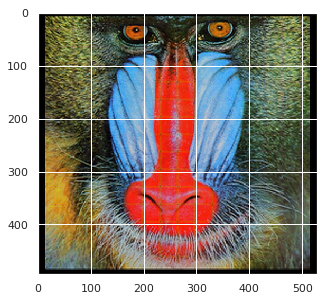

In [13]:

plt.figure(figsize=(5, 5))
plt.imshow(output)
